# Quick introduction to Data Augmentor
Small and imbalanced datasets are a big problem. They are suffer from similar challenges such that they may not generalize well, tend to overfit, biased and lacked performance.  
Sometimes augment the dataset can remedy some of the challenges.  
Our implementation of all-in-one DataAugmentor, including our novel implemetation using counterfactuals examples can help to tackle those challenges.  
The solution is model and data agnostic (works for all complex models and all kind of datasets).

Below is a small example, how this idea can mitigate limitations of small datasets.   
In this example we will use the `Diabetes Dataset` which is a regression task.
Diabetes Dataset is a medical datasets, collected from patients. Its an excellent example due to the fact that it is a small dataset.  
After it there is an example for a binary classification task using the `Adult Dataset`. In this example, because Adult is a large datase, it allowed us to sample small dataset from it and then to test if the augmentation improve results and if so, how much comparing to using whole data.   

You can see all of our detailed experiments, for different kind of datasets and models in `experimetns/` folder.

### Initialization
Installing requirements, auto reload changing to code, imports and some configurations

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from helpers import utils, pipelines, models
from sklearn.model_selection import train_test_split
from data_augmentaion.data_augmentator import DataAugmentor 
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [4]:
# disable tqdm progress bar by default
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

## Diabetes Dataset - Regression

### Load data

In [5]:
df = pd.read_csv(r"datasets/diabetes.txt", sep='\t')
target = 'Y'

### split data

In [6]:
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)

#### define continuous_features

In [7]:
continuous_features = ['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']

### Target distribution in train
Can be seen that this is a small and a little bit skew dataset

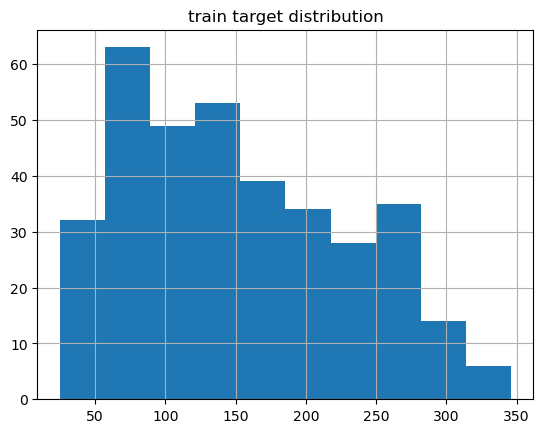

In [8]:
ax = y_train.hist()
ax.set_title('train target distribution')
plt.show()

### Train a model without any augmentation

#### define research space to find best model

In [9]:
search_pipelines = pipelines.get_regression_pipelines()
search_parameters = models.regression_parameters
metrics = ['neg_root_mean_squared_error', 'r2']

#### Train

In [10]:
best_estimators, best_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                                                      search_estimators=search_pipelines, 
                                                      search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(best_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df.T)

lr      ridge      lasso         rf  \
whole neg_root_mean_squared_error -53.853446 -53.842869 -53.774196 -53.762652   
      r2                            0.452603   0.453519   0.454213   0.454447   

                                         xgb  
whole neg_root_mean_squared_error -53.924630  
      r2                            0.451155

### Augmenting Data
Our DataAugmentor implements several oversampling methods, all model and data agnostics:
* Random over sampling
* SMOTE
* counterfactuals method:
  * Randomized sampling
  * KD-Tree (for counterfactuals within the training data)
  * Genetic algorithm



In this case could take several minutes. Obtaining data is hard and expensive, so how much it several minutes for meaningfull improvment? Please wait, Patience pays :) 

##### Define important parameters for augmentation

In [11]:
method = 'cf_random'
augment_sample = 0.5

##### Augmenting
We use the random algorithm for counterfactulas generation and we augmenting the data by 50% of its original size by sampling in random without balancing.

In [12]:
augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                            method=method, regression=True,
                            continuous_feats=continuous_features,
                            )
X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)

model for cf neg_root_mean_squared_error score: {'cf': {'neg_root_mean_squared_error': -53.59294397603038}}
0/176
50/176
100/176
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
150/176


### Train model on new augmented data

In [13]:
best_estimators_augmented, best_scores_augmented = utils.fit_and_evaluate(X_train_augmented,
                                                                          y_train_augmented,
                                                                          X_test, y_test,
                                                                          search_estimators=search_pipelines,
                                                                          search_params=search_parameters,
                                                                          scoring=metrics)
result_df_augmented = pd.DataFrame.from_dict(best_scores_augmented, orient='index')
result_df_augmented.columns = pd.MultiIndex.from_product([[f'{method}']] + [result_df_augmented.columns])

### Results

#### Detailed performances

In [14]:
full_results_df = pd.concat([whole_dataset_result_df, result_df_augmented], axis=1)
full_results_df

whole                             cf_random  \
      neg_root_mean_squared_error        r2 neg_root_mean_squared_error   
lr                     -53.853446  0.452603                  -53.449001   
ridge                  -53.842869  0.453519                  -53.443422   
lasso                  -53.774196  0.454213                  -52.771352   
rf                     -53.762652  0.454447                  -53.201920   
xgb                    -53.924630  0.451155                  -52.980514   

                 
             r2  
lr     0.460794  
ridge  0.460906  
lasso  0.474380  
rf     0.465768  
xgb    0.484288

#### Best model comparison

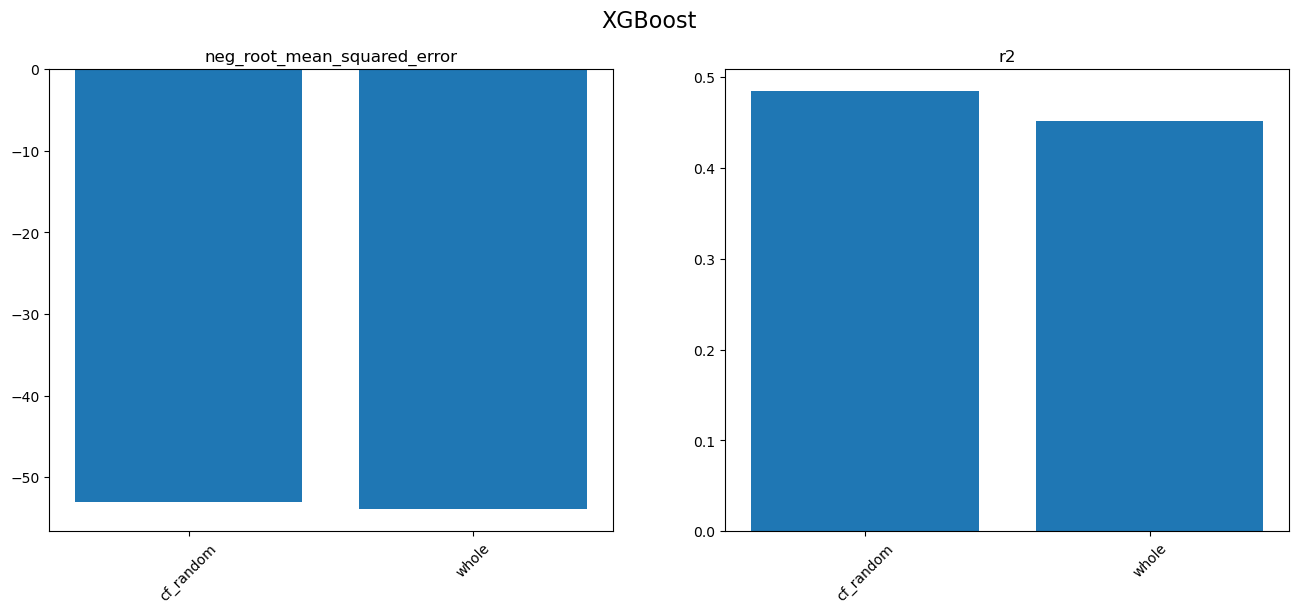

In [15]:
utils.bar_plot(full_results_df, model='xgb')

### Conclusion
In short, augmenting the data slightly improves the metrics.   
If we looks on the distribution of the augmented data, we can see it is less skew and more "normal" what can be a possible explanation besides just the augmentation.

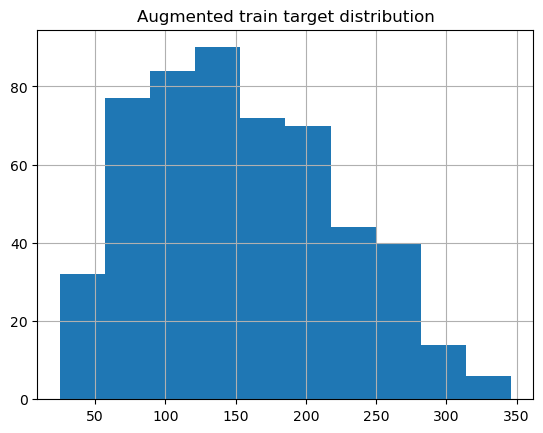

In [16]:
ax = y_train_augmented.hist()
ax.set_title('Augmented train target distribution')
plt.show()

## Adult Dataset - Binary Classification

### Load data

In [17]:
raw_data = pd.read_csv("datasets/adult.csv")
df = utils.preprocess_adult(raw_data)
target = 'income'

### Split data

In [18]:
test_size_proportion = 0.2

sample_frac = 0.05 # Fraction of the original dataset considered

#### Whole data

In [19]:
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

#### Sampled data

In [20]:
df_sample = df.sample(frac=sample_frac, random_state=42)
X_sample = df_sample.drop(target, axis=1)
y_sample = df_sample[target]
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=test_size_proportion, random_state=42)

### define continuous features


In [21]:
continuous_features = ['age', 'fnlwgt', 'hours-per-week']

### Target distribution in train
Can be seen that this is a relatively small and imbalance dataset

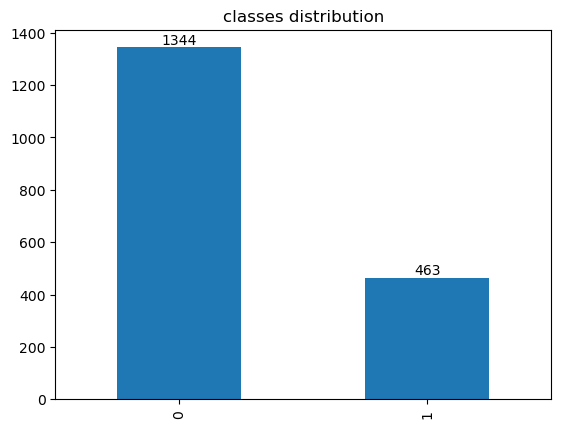

In [22]:
ax = y_sample_train.value_counts().sort_index().plot(kind='bar')
ax.set_title('classes distribution')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()-25), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

### Train a model without any augmentation

#### define research space to find best model

In [23]:
search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters
metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']

#### Train on whole data

In [24]:
whole_estimators, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                                                      search_estimators=search_pipelines, 
                                                      search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df.T)

lg        rf       xgb
whole f1         0.611430  0.557895  0.633659
      accuracy   0.828224  0.823354  0.833758
      precision  0.676717  0.777262  0.680795
      recall     0.558596  0.459188  0.592339
      roc_auc    0.883247  0.877579  0.890927

#### Train on 5% sampled data

In [25]:
sampled_estimators, sampled_scores = utils.fit_and_evaluate(X_sample_train, y_sample_train,
                                                            X_sample_test, y_sample_test,
                                                            search_estimators=search_pipelines, 
                                                            search_params=search_parameters, scoring=metrics)
sampled_dataset_result_df = pd.DataFrame.from_dict(sampled_scores, orient='index')
sampled_dataset_result_df.columns = pd.MultiIndex.from_product([['sample']] + [sampled_dataset_result_df.columns])
display(sampled_dataset_result_df.T)

lg        rf       xgb
sample f1         0.604396  0.375000  0.558659
       accuracy   0.845133  0.823009  0.825221
       precision  0.662500  0.807692  0.602410
       recall     0.572917  0.250000  0.520833
       roc_auc    0.863150  0.851826  0.848124

### Augmenting Data
Our DataAugmentor implements several oversampling methods, all model and data agnostics:
* Random over sampling
* SMOTE
* counterfactuals method:
  * Randomized sampling
  * KD-Tree (for counterfactuals within the training data)
  * Genetic algorithm



In this case could take several minutes. Obtaining data is hard and expensive, so how much it several minutes for meaningfull improvment? Please wait, Patience pays :) 

##### Define important parameters for augmentation

In [26]:
method = 'cf_genetic'
kw_args = {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}
augment_sample = 0.5

##### Augmenting
We use the genetic algorithm for counterfactulas generation and we augmenting the data by 50% of its 5% sampled size by sampling in random without balancing.

In [27]:
augmentor = DataAugmentor(X_sample_train, y_sample_train, X_sample_test, y_sample_test,
                            method=method, regression=False,
                            continuous_feats=continuous_features,
                            kw_args=kw_args
                            )
X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)

model for cf f1 score: {'cf': {'f1': 0.6021505376344086}}
0/903
50/903
100/903
150/903
200/903
250/903
300/903
350/903
400/903
450/903
500/903
550/903
600/903
650/903
700/903
750/903
800/903
850/903
900/903


### Train model on new augmented data

In [28]:
best_estimators_augmented, best_scores_augmented = utils.fit_and_evaluate(X_train_augmented,
                                                                          y_train_augmented,
                                                                          X_sample_test, y_sample_test,
                                                                          search_estimators=search_pipelines,
                                                                          search_params=search_parameters,
                                                                          scoring=metrics)
result_df_augmented = pd.DataFrame.from_dict(best_scores_augmented, orient='index')
result_df_augmented.columns = pd.MultiIndex.from_product([[f'{method}']] + [result_df_augmented.columns])

### Results

#### Detailed performances

In [29]:
full_results_df = pd.concat([whole_dataset_result_df, sampled_dataset_result_df, result_df_augmented], axis=1)
full_results_df

whole                                            sample            \
           f1  accuracy precision    recall   roc_auc        f1  accuracy   
lg   0.611430  0.828224  0.676717  0.558596  0.883247  0.604396  0.845133   
rf   0.557895  0.823354  0.777262  0.459188  0.877579  0.375000  0.823009   
xgb  0.633659  0.833758  0.680795  0.592339  0.890927  0.558659  0.825221   

                                  cf_genetic                                \
    precision    recall   roc_auc         f1  accuracy precision    recall   
lg   0.662500  0.572917  0.863150   0.628571  0.827434  0.578947  0.687500   
rf   0.807692  0.250000  0.851826   0.595745  0.803097  0.527132  0.729167   
xgb  0.602410  0.520833  0.848124   0.572770  0.798673  0.521368  0.604167   

               
      roc_auc  
lg   0.850538  
rf   0.853669  
xgb  0.844101

#### Best model comparison

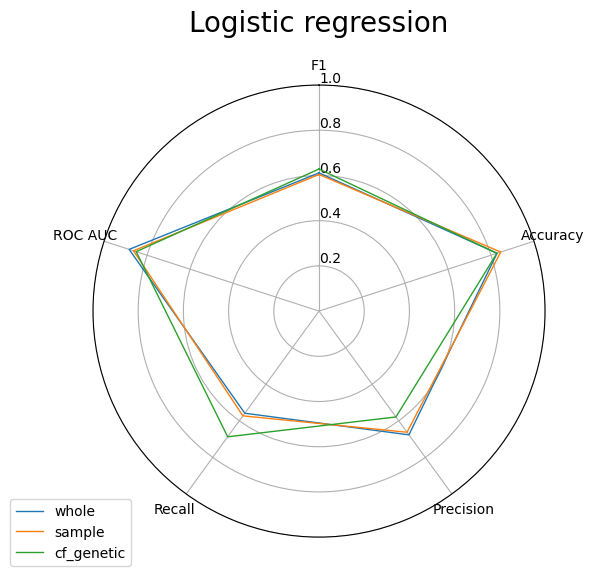

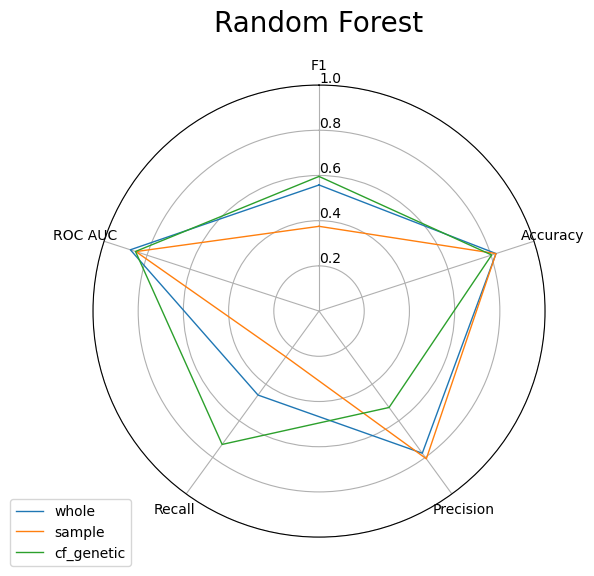

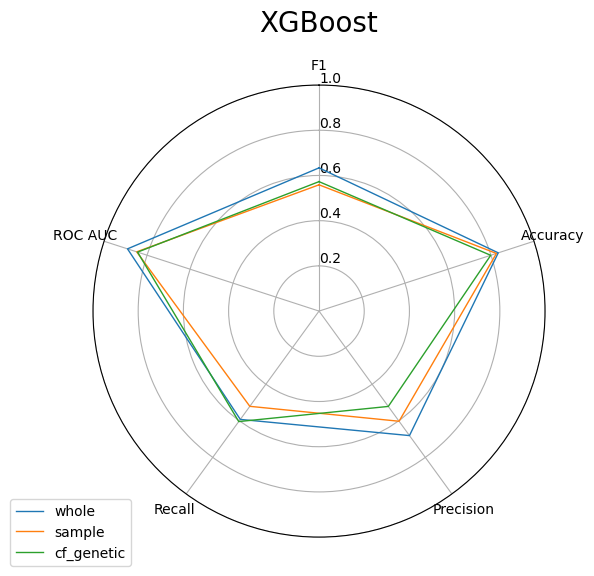

In [30]:
wanted_cols = ['whole', 'sample', 'cf_genetic']
metric_names = {'f1': 'F1',
                'accuracy': 'Accuracy',
                'precision': 'Precision',
                'recall': 'Recall',
                'roc_auc': 'ROC AUC'}
utils.spider_plot(full_results_df, 'lg', wanted_cols, metric_names, 'Logistic regression')
utils.spider_plot(full_results_df, 'rf', wanted_cols, metric_names, 'Random Forest')
utils.spider_plot(full_results_df, 'xgb', wanted_cols, metric_names, 'XGBoost')

### Conclusion
We can see that the augmenting data using genetic algorithm for generating counterfactuals, significantly improve Recall compare to the sample data, but at the cost of reducing precision. The recall score is competetive with the whole data what is quite impressing.